#### Урок 4. ДЗ ####

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)
# classification_data, classification_labels = make_circles(n_samples=30, random_state=5)

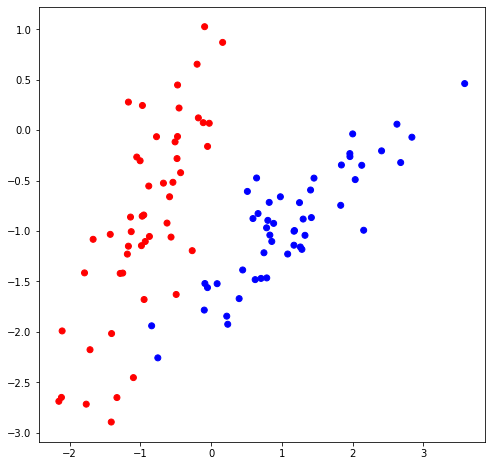

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)

        return prediction        

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = 1 - \sum_{k=1}^K{p_k^2} ,$$


In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

$$H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$


In [7]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 3

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [10]:
import time
# Построение дерева с помощью рекурсивной функции

# ==============================
#РЕШЕНИЕ ограничение глубины дерева (добавлены параметры max_deep, curr_max_deep)
# ==============================

def build_tree(data, labels, max_deep=np.inf, curr_max_deep=0):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)
    
    # Прекращаем рекурсию при достижении максимальной глубины дерева
    if max_deep <= curr_max_deep:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    curr_max_deep += 1 #следующая глубина дерева
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_deep, curr_max_deep)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels, max_deep, curr_max_deep)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction

        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [14]:
# Построим дерево по обучающей выборке
max_deep = 3
my_tree = build_tree(train_data, train_labels, max_deep)

In [15]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0 <= 0.16261402870113306
--> True:
  Индекс 1 <= -1.5208896621663803
  --> True:
    Индекс 0 <= -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [16]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [17]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [18]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [19]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [20]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

In [21]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

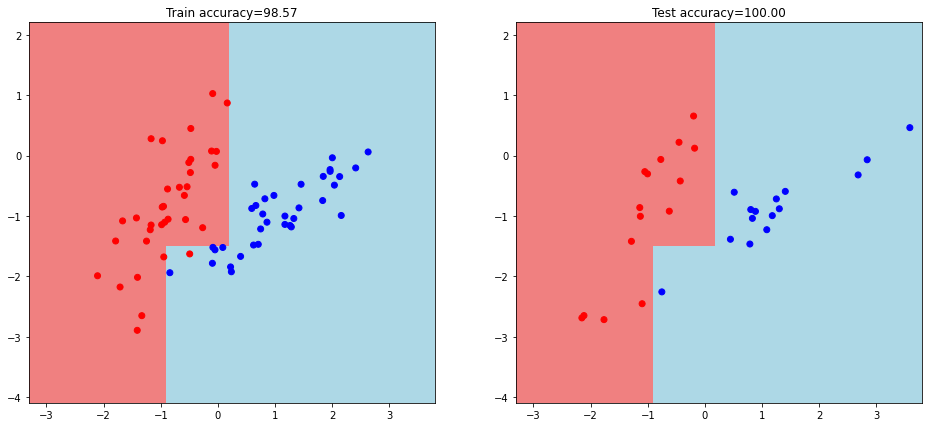

In [22]:
visualize(train_data, test_data)

In [23]:
df_full = pd.read_csv('./data/cardio.csv', sep=';')

features = ['age', 'height']
target = ['cardio']

df = df_full[features + target]
print(df.shape)

train_data, test_data, train_labels, test_labels = train_test_split(df[features].values, 
                                                                    np.squeeze(df[target].values),
                                                                    test_size=0.3,
                                                                    random_state=1)

(70000, 3)


In [24]:
%%time
max_deep = 3
my_tree = build_tree(train_data, train_labels, max_deep)

CPU times: user 5.14 s, sys: 31.6 ms, total: 5.18 s
Wall time: 5.21 s


In [25]:
print_tree(my_tree)

Индекс 0 <= 54
--> True:
  Индекс 0 <= 44
  --> True:
    Индекс 0 <= 40
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Индекс 0 <= 50
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
--> False:
  Индекс 0 <= 60
  --> True:
    Индекс 0 <= 58
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1
  --> False:
    Индекс 0 <= 62
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1


In [26]:
train_answers = predict(train_data, my_tree)
test_answers = predict(test_data, my_tree)

In [27]:
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)

print(f'Train accuracy', train_accuracy)
print(f'Test accuracy', test_accuracy)

Train accuracy 59.80408163265306
Test accuracy 59.69523809523809


CPU times: user 4 s, sys: 98.5 ms, total: 4.09 s
Wall time: 4.12 s


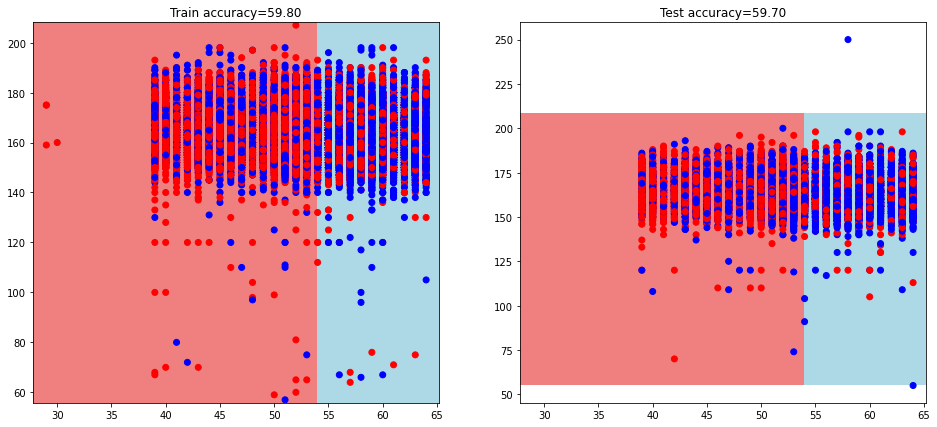

In [28]:
%%time
visualize(train_data, test_data)

In [29]:
dt = DecisionTreeClassifier()
dt.fit(train_data, train_labels)

train_answers = dt.predict(train_data)
test_answers = dt.predict(test_data)

train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)

print(f'Train accuracy', train_accuracy)
print(f'Test accuracy', test_accuracy)

Train accuracy 61.559183673469384
Test accuracy 58.352380952380955


In [30]:
accuracy_score(train_answers, train_labels) * 100

61.559183673469384

<hr>

2. *Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [31]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.target)        

In [32]:
def calc_mse(target):
    return np.mean((target - np.mean(target))**2)

In [97]:
# Расчет прироста

def gain(left_labels, right_labels, root_mse):
  
    n_total = left_labels.shape[0] + right_labels.shape[0]
    
    return root_mse - (left_labels.shape[0] * calc_mse(left_labels) / n_total + 
                        right_labels.shape[0] * calc_mse(right_labels) / n_total)

In [74]:
# Нахождение наилучшего разбиения (регрессия)

def find_best_split(data, target):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 3
    
    root_mse = calc_mse(target)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_target, false_target = split(data, target, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_target, false_target, root_mse)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [35]:
import time
# Построение дерева с помощью рекурсивной функции

# ==============================
#РЕШЕНИЕ ограничение глубины дерева (добавлены параметры max_deep, curr_max_deep)
# ==============================

def build_tree(data, target, max_deep=np.inf, curr_max_deep=0):

    gain, t, index = find_best_split(data, target)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, target)
    
    # Прекращаем рекурсию при достижении максимальной глубины дерева
    if max_deep <= curr_max_deep:
        return Leaf(data, target)

    true_data, false_data, true_target, false_target = split(data, target, index, t)

    curr_max_deep += 1 #следующая глубина дерева
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_target, max_deep, curr_max_deep)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_target, max_deep, curr_max_deep)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [36]:
df_full_regression = pd.read_csv('./data/cardio.csv', sep=';')

features = ['height', 'cardio']
target = ['age']

df = df_full[features + target]
print(df.shape)

train_data, test_data, train_target, test_target = train_test_split(df[features].values, 
                                                                    np.squeeze(df[target].values),
                                                                    test_size=0.3,
                                                                    random_state=1)

(70000, 3)


In [93]:
%%time
my_tree = build_tree(train_data, train_target)

CPU times: user 488 ms, sys: 15 ms, total: 503 ms
Wall time: 511 ms


In [94]:
print_tree(my_tree)

Индекс 1 <= 0
--> True:
  Индекс 0 <= 158
  --> True:
    Индекс 0 <= 149
    --> True:
      Индекс 0 <= 142
      --> True:
        Индекс 0 <= 70
        --> True:
          Индекс 0 <= 65
          --> True:
            Прогноз: 52.8
          --> False:
            Прогноз: 43.6
        --> False:
          Индекс 0 <= 76
          --> True:
            Прогноз: 61.0
          --> False:
            Индекс 0 <= 110
            --> True:
              Индекс 0 <= 99
              --> True:
                Прогноз: 50.0
              --> False:
                Прогноз: 43.25
            --> False:
              Индекс 0 <= 141
              --> True:
                Индекс 0 <= 138
                --> True:
                  Индекс 0 <= 136
                  --> True:
                    Индекс 0 <= 128
                    --> True:
                      Индекс 0 <= 120
                      --> True:
                        Прогноз: 49.76923076923077
                      --> False

In [95]:
train_answers = predict(train_data, my_tree)
test_answers = predict(test_data, my_tree)

In [96]:
from sklearn.metrics import r2_score

train_r2 = r2_score(train_target, train_answers)
test_r2 = r2_score(test_target, test_answers)

train_r2, test_r2



(0.06838291728614398, 0.06308486122864254)